In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.metrics import confusion_matrix

from google.colab import drive
import zipfile
from tqdm import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

#### Функции

In [ ]:
def test(model, test_dl, loss_function, linear=True):
    accuracy = 0
    loss = 0
    count = 0
    with torch.no_grad():
        for index, (input, target) in enumerate(test_dl, 1):
            input, target = input.to(device), target.to(device)
            if linear:
              input = input.view(input.shape[0], -1)
            output = model(input)
            accuracy += torch.sum(torch.eq(output.argmax(dim=1).long(), target))
            count += output.shape[0]
            loss += loss_function(output, target)

    return float(accuracy / count), float(loss / index)

In [ ]:
def train(model, train_dl, test_dl, epochs = 10, learning_rate = 0.01, linear=True):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    history = pd.DataFrame(columns=['epoch', 'train loss', 'train accuracy', 'val loss', 'test accuracy'])

    for epoch in range(epochs):
      model.train()

      train_loss = 0.0
      total_samples = 0.0
      correct_samples = 0.0

      for index, (inputs, targets) in enumerate(train_dl, 1):
        inputs, targets = inputs.to(device), targets.to(device)
        if linear:
          inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
        total_samples += targets.shape[0]

        _, prediction_indices = torch.max(outputs, 1)
        correct_samples += torch.sum(prediction_indices==targets)

      train_loss = float(train_loss/index)
      train_accuracy = float(correct_samples) / total_samples
      test_accuracy, val_loss = test(model, test_dl, criterion, linear)
      history.loc[epoch] = [epoch, train_loss, train_accuracy, val_loss, test_accuracy]

      if (epoch+1)%5==0 or epoch==0:
        print(f"epoch[{epoch+1}]: train loss - {train_loss:.3f}, train accuracy - {train_accuracy:.3f}, val loss - {val_loss:.3f}, test accuracy - {test_accuracy:.3f}")

    return model, history

In [ ]:
def train_test_info(history):
  fig, _axs = plt.subplots(nrows=2, figsize=(10, 10))
  axs = _axs.flatten()
  axs[0].plot(history['train loss'], label='Train loss')
  axs[0].plot(history['val loss'], label='Val loss')
  axs[0].legend(frameon=False);
  axs[1].plot(history['train accuracy'], label='Train accuracy')
  axs[1].plot(history['test accuracy'], label='Test accuracy')
  axs[1].legend(frameon=False)
  plt.show()

In [ ]:
def show_images(model, test_dl, test_ds, image_size, num_imgs=3, figsize=(20, 20), linear=True, onedim=True):
  fig, _axs = plt.subplots(nrows=num_imgs, figsize=figsize)
  axs = _axs.flatten()

  model.eval()
  with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        if linear:
          inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        _, predictions_indices = torch.max(outputs, 1)
        for i, (ex_inp, ex_targ, ex_pred) in enumerate(zip(inputs, targets, predictions_indices)):
            axs[i].set_title(f"index: {i}, true: {test_ds.classes[ex_targ]}, predicted: {test_ds.classes[ex_pred]}")
            if onedim:
              axs[i].imshow(ex_inp.cpu().view(image_size))
            else:
              axs[i].imshow(ex_inp.cpu().view(image_size).permute(1, 2, 0))
            if i==num_imgs-1:
                break
        plt.show()
        break

In [ ]:
def proccess_image(model, test_dl, linear=True):
  pic, target = next(iter(test_dl))
  if linear:
    pic = pic.view(pic.shape[0], -1)
  fst_pic = model[:2](pic.to(device))[0][:5]
  for pic_i in fst_pic:
    fig = make_subplots(1, 2)
    plt.imshow(pic_i.detach().cpu().numpy())
    plt.show()

In [ ]:
def conf_mat(model, test_dl, test_ds, linear=True):
  model.eval()
  true = torch.empty(0).to(device)
  predict = torch.empty(0).to(device)

  with torch.no_grad():
    for inputs, targets in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        if linear:
          inputs = inputs.view(inputs.shape[0], -1)

        outputs = model(inputs)

        _, predictions_indices = torch.max(outputs, 1)

        true = torch.cat((true, targets))
        predict = torch.cat((predict, predictions_indices))

  plt.figure(figsize=(14,12))
  sns.heatmap(
    pd.DataFrame(
        confusion_matrix(true.cpu().numpy().astype("int"), predict.cpu().numpy().astype("int")),
    ),
    annot=True,
    fmt="d",
    xticklabels=test_ds.classes,
    yticklabels=test_ds.classes
  );

  total_accuracy = torch.sum(true==predict) / true.shape[0]
  print(f"total accuracy: {total_accuracy:.3f}")

## 1. Классификация предметов одежды (датасет Fashion MNIST)


In [ ]:
batch_size = 100
shuffle_dataset = True

train_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())
train_dl = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=shuffle_dataset)

test_dl = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 11213898.52it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 172173.12it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3342932.67it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6643777.54it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




### 1.1 Решить задачу классификации, не используя сверточные слои.
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
num_classes = 10
input_size = 1*28*28
hidden_size1 = 512
hidden_size2 = 216

In [ ]:
model = torch.nn.Sequential(
    nn.Linear(input_size, hidden_size1),
    nn.ReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.ReLU(),
    nn.Linear(hidden_size2, num_classes),
).to(device)

In [ ]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 514898


In [ ]:
model, history = train(model, train_dl, test_dl, epochs=30, learning_rate=0.0005)

epoch[1]: train loss - 0.564, train accuracy - 0.801, val loss - 0.464, test accuracy - 0.831
epoch[5]: train loss - 0.294, train accuracy - 0.892, val loss - 0.351, test accuracy - 0.873
epoch[10]: train loss - 0.230, train accuracy - 0.915, val loss - 0.328, test accuracy - 0.882
epoch[15]: train loss - 0.188, train accuracy - 0.930, val loss - 0.341, test accuracy - 0.890
epoch[20]: train loss - 0.153, train accuracy - 0.942, val loss - 0.335, test accuracy - 0.896
epoch[25]: train loss - 0.127, train accuracy - 0.951, val loss - 0.360, test accuracy - 0.897
epoch[30]: train loss - 0.102, train accuracy - 0.962, val loss - 0.388, test accuracy - 0.898


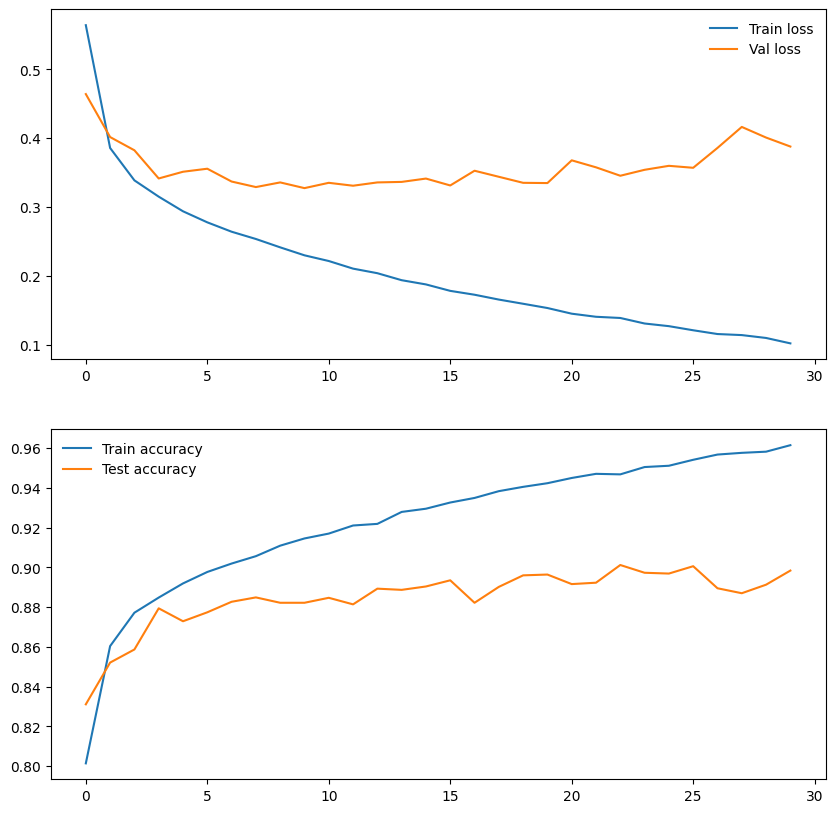

In [ ]:
train_test_info(history)

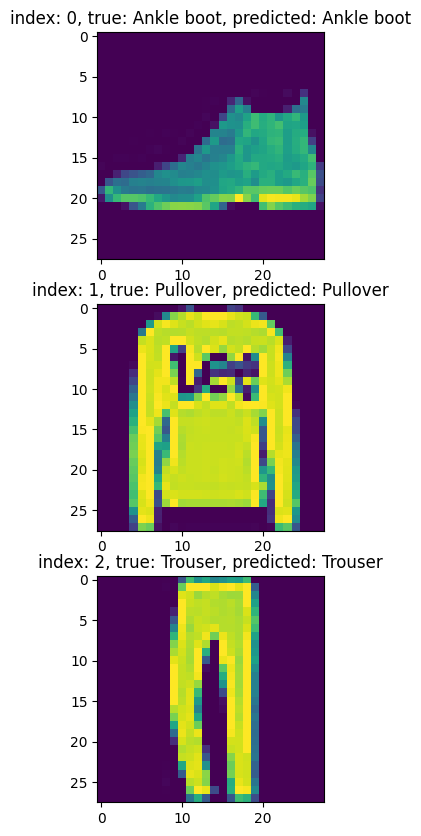

In [ ]:
show_images(model, test_dl, test_dataset, image_size=(28, 28), figsize=(10, 10))

total accuracy: 0.898


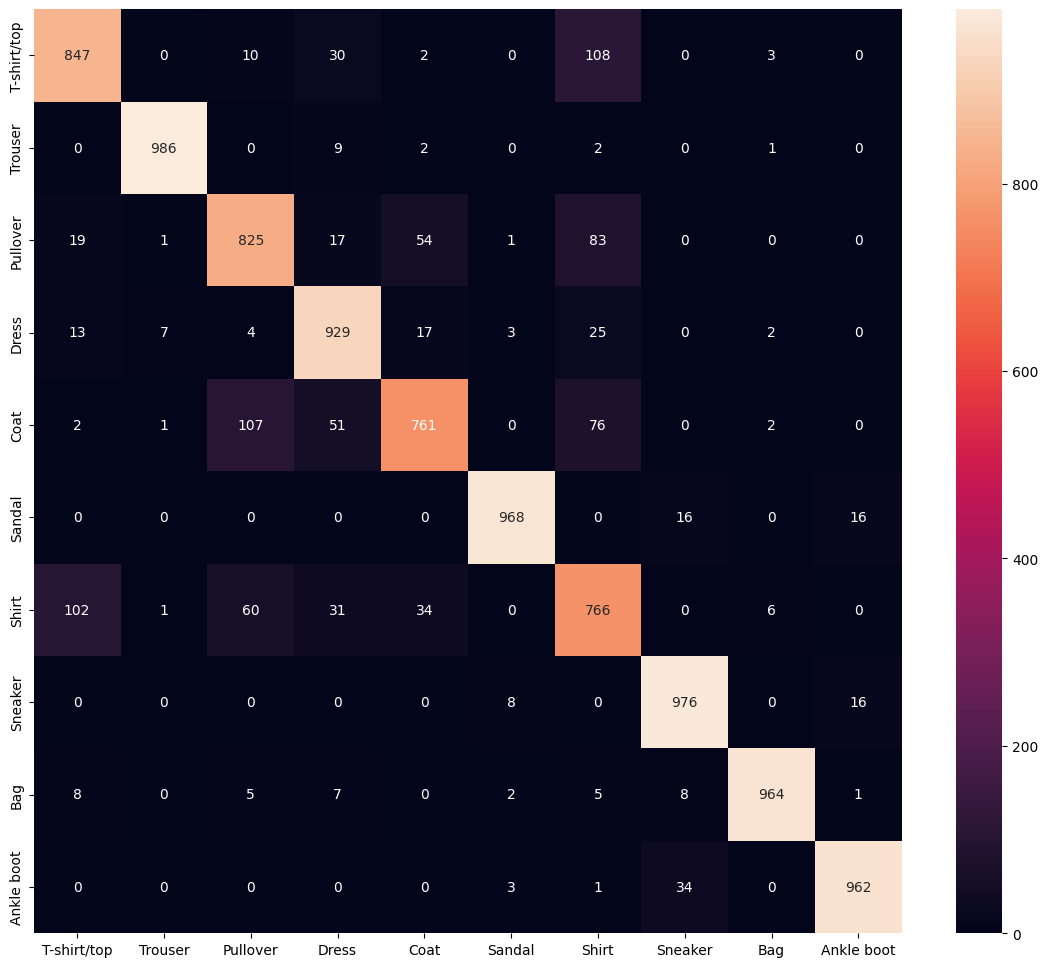

In [ ]:
conf_mat(model, test_dl, test_dataset)

In [ ]:
torch.save(model.state_dict(), 'fashion_model_not_CNN.pth')

### 1.2 Решить задачу 1.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
p = 0.4
learning_rate = 0.001
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, (5, 5), stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2), stride=2),

    torch.nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2, 2), stride=2),

    torch.nn.Dropout(p),

    torch.nn.Flatten(),
    torch.nn.Linear(7*7*64, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 10)

).to(device)


In [ ]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 3199106


In [ ]:
model, history = train(model, train_dl, test_dl, epochs=20, learning_rate=0.001, linear=False)

epoch[1]: train loss - 0.469, train accuracy - 0.827, val loss - 0.356, test accuracy - 0.867
epoch[5]: train loss - 0.203, train accuracy - 0.924, val loss - 0.262, test accuracy - 0.905
epoch[10]: train loss - 0.124, train accuracy - 0.952, val loss - 0.252, test accuracy - 0.916
epoch[15]: train loss - 0.077, train accuracy - 0.971, val loss - 0.319, test accuracy - 0.915
epoch[20]: train loss - 0.054, train accuracy - 0.979, val loss - 0.360, test accuracy - 0.917


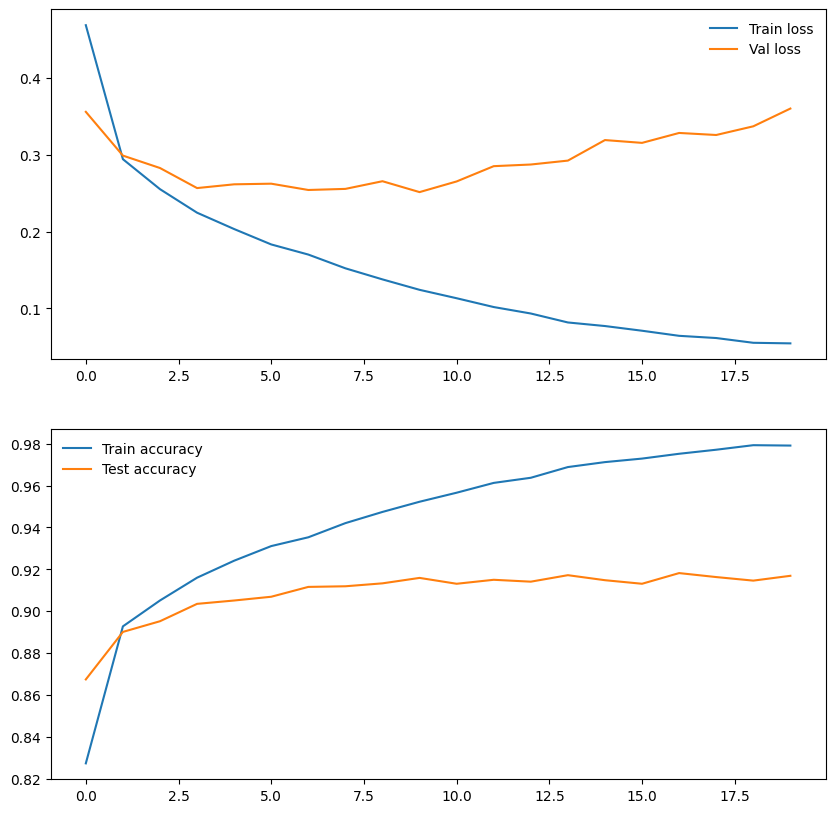

In [ ]:
train_test_info(history)

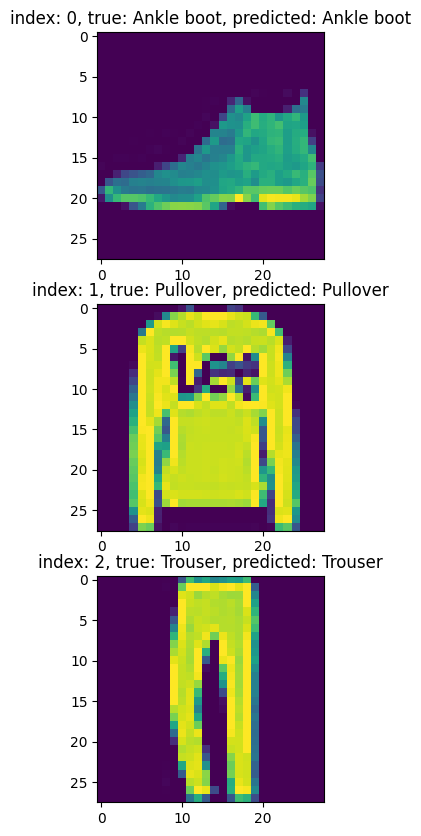

In [ ]:
show_images(model, test_dl, test_dataset, image_size=(28, 28), figsize=(10, 10), linear=False)

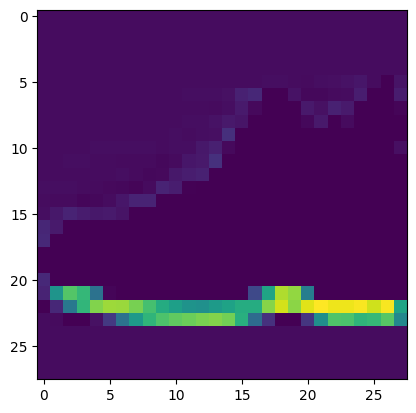

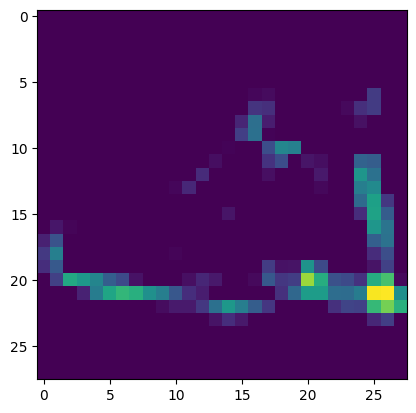

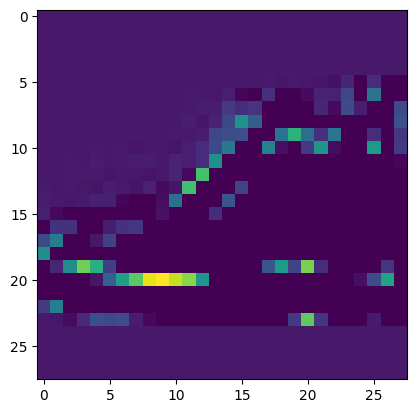

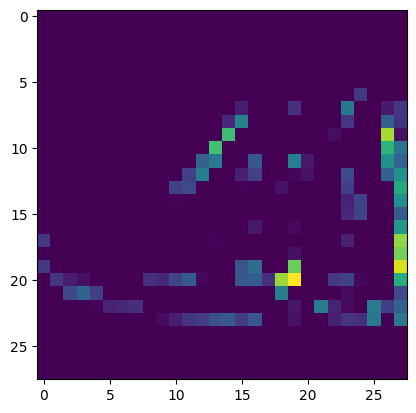

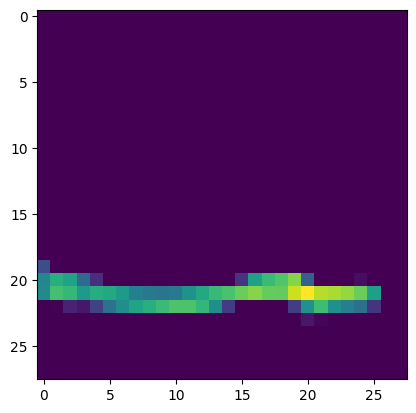

In [ ]:
proccess_image(model, test_dl, linear=False)

total accuracy: 0.926


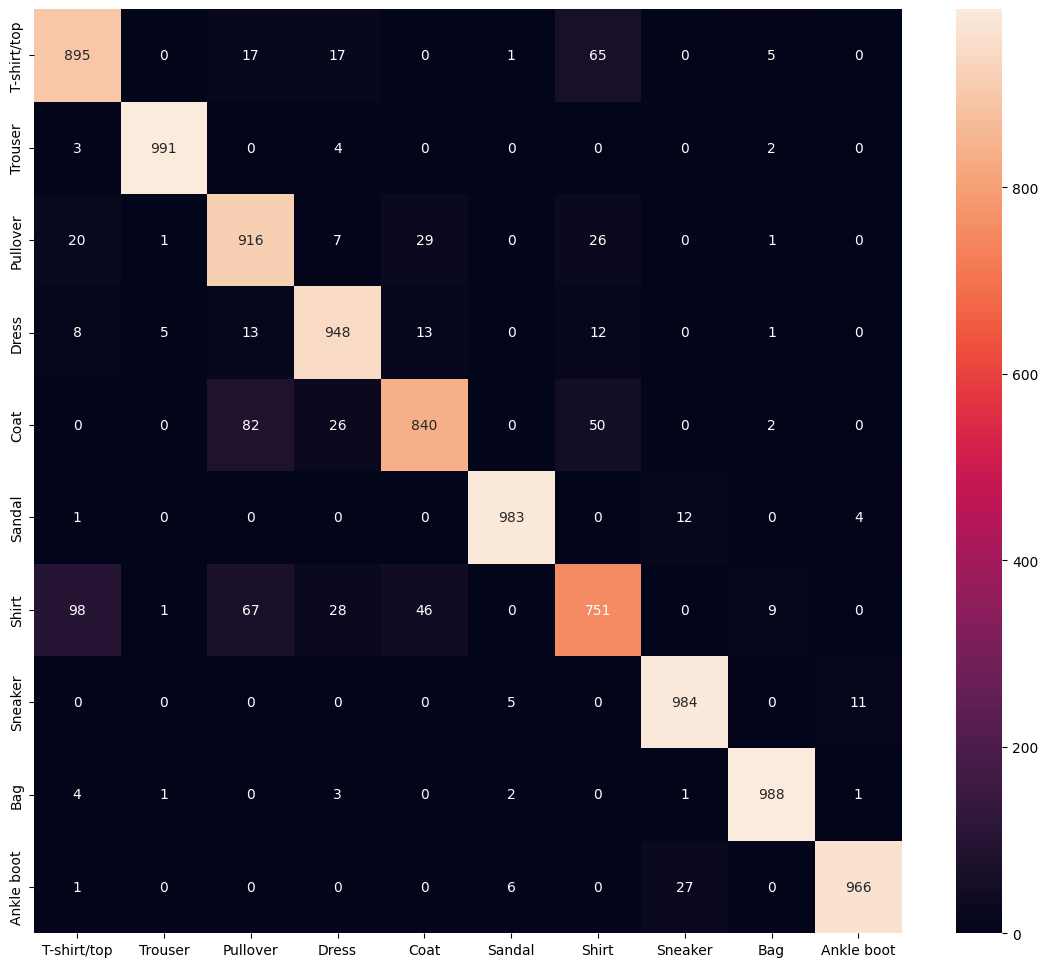

In [ ]:
conf_mat(model, test_dl, test_dataset, linear=False)

##  2. Классификация изображений (датасет CIFAR 10)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 13073043.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



### 2.1 Решить задачу классификации, не используя сверточные слои.

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

In [ ]:
im_size = 32*32*3
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
hidden_size4 = 64
num_classes = 10

In [ ]:
model = nn.Sequential(
    nn.Linear(im_size, hidden_size1),
    nn.ReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.ReLU(),
    nn.Linear(hidden_size2, hidden_size3),
    nn.ReLU(),
    nn.Linear(hidden_size3, hidden_size4),
    nn.ReLU(),
    nn.Linear(hidden_size4, num_classes)
).to(device)

In [ ]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 1746506


In [ ]:
model, history = train(model, train_dl, test_dl, epochs=20, learning_rate=0.001)

epoch[1]: train loss - 1.781, train accuracy - 0.359, val loss - 1.625, test accuracy - 0.410
epoch[5]: train loss - 1.387, train accuracy - 0.509, val loss - 1.492, test accuracy - 0.476
epoch[10]: train loss - 1.217, train accuracy - 0.572, val loss - 1.532, test accuracy - 0.506
epoch[15]: train loss - 1.071, train accuracy - 0.627, val loss - 1.693, test accuracy - 0.510
epoch[20]: train loss - 0.955, train accuracy - 0.668, val loss - 1.723, test accuracy - 0.514


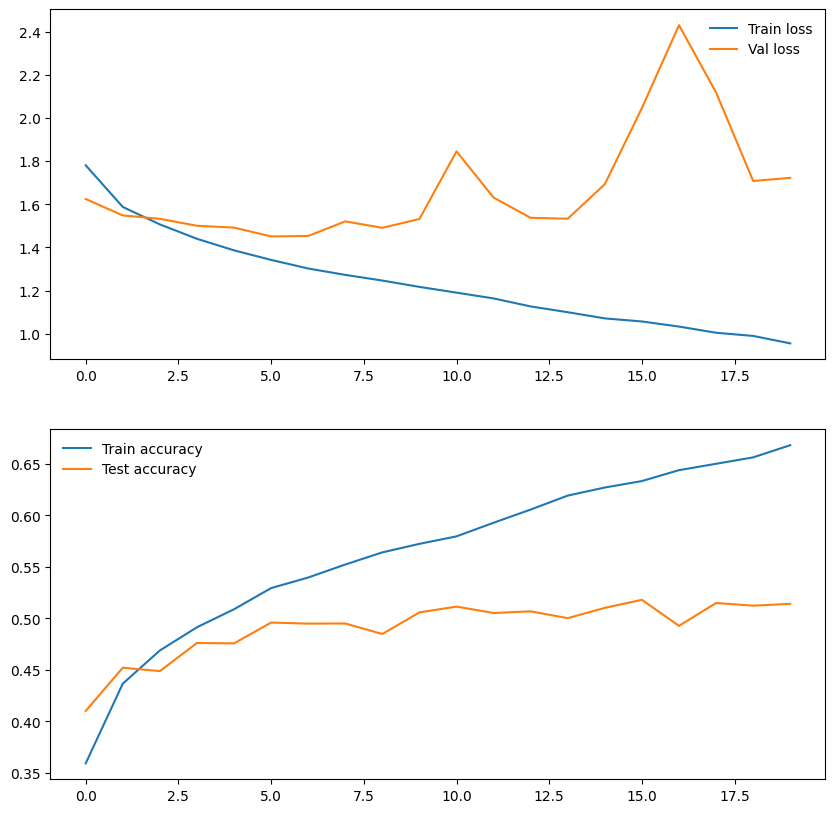

In [ ]:
train_test_info(history)

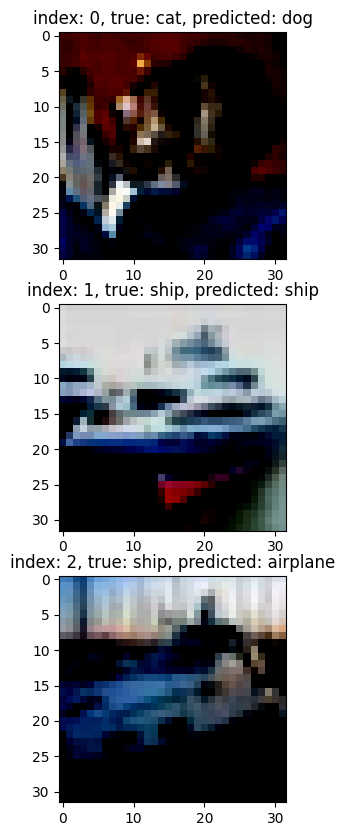

In [ ]:
show_images(model, test_dl, test_dataset, image_size=(3, 32, 32), figsize=(10, 10), onedim=False)

total accuracy: 0.514


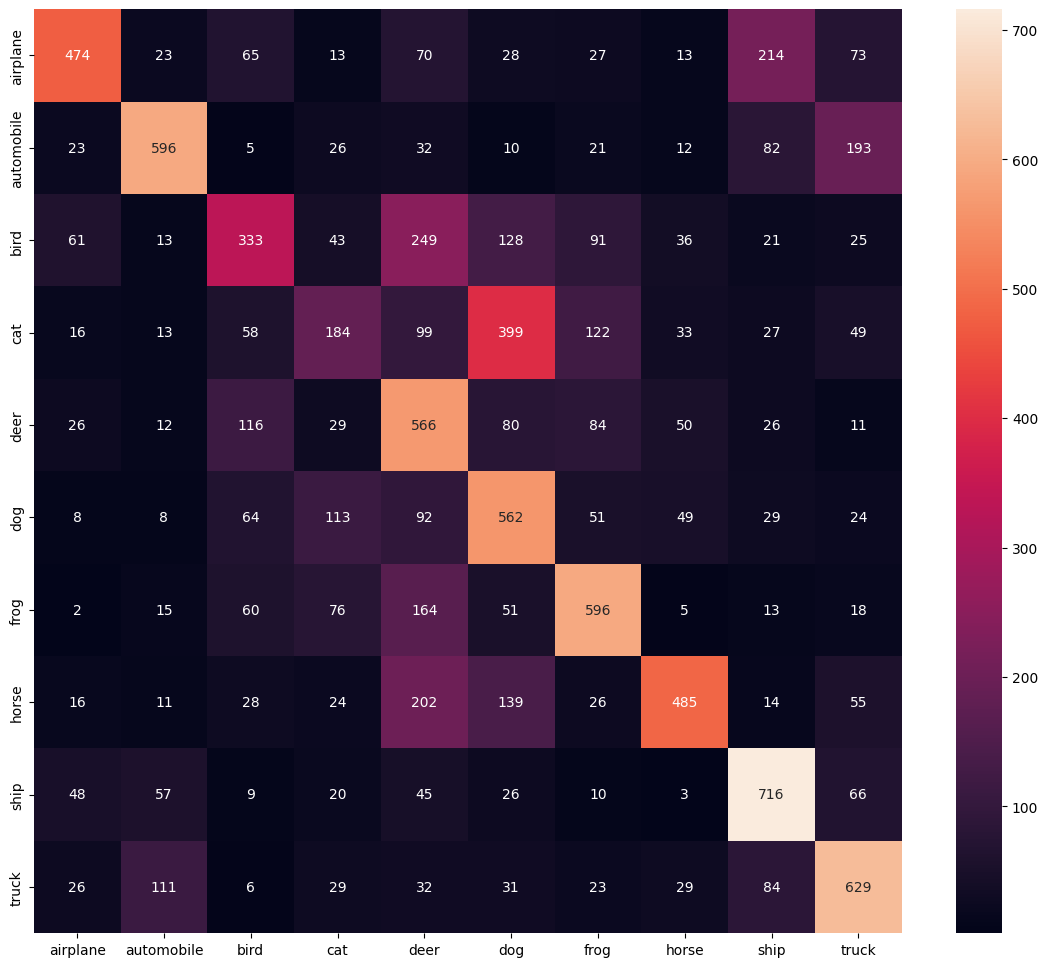

In [ ]:
conf_mat(model, test_dl, test_dataset)

In [ ]:
torch.save(model.state_dict(), 'cifar_model_not_CNN.pth')

### 2.2 Решить задачу 2.1, используя сверточную нейронную сеть.
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
p = 0.7
model = torch.nn.Sequential(

    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(3, 16, (5, 5), padding=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(16),
    torch.nn.Conv2d(16, 64, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(64),
    torch.nn.Conv2d(64, 128, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(128),
    torch.nn.Conv2d(128, 256, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.Flatten(),
    torch.nn.Dropout(p),
    torch.nn.Linear(256*2*2, 1024),
    torch.nn.CELU(),
    torch.nn.Linear(1024, len(train_dataset.classes))
).to(device)

In [ ]:
p = 0.5
model = torch.nn.Sequential(

    torch.nn.Conv2d(3, 16, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.Conv2d(16, 64, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.Conv2d(64, 64, (3, 3), padding=1),
    torch.nn.ReLU(),

    torch.nn.Conv2d(64, 128, (3, 3), padding=1),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.ReLU(),

    torch.nn.Flatten(),
    torch.nn.Dropout(p),
    torch.nn.Linear(16 * 128, len(train_dataset.classes))
).to(device)


In [ ]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 141296


In [ ]:
model, history = train(model, train_dl, test_dl, epochs=20, learning_rate=0.001, linear=False)

epoch[1]: train loss - 1.506, train accuracy - 0.472, val loss - 1.267, test accuracy - 0.565
epoch[5]: train loss - 0.858, train accuracy - 0.706, val loss - 0.974, test accuracy - 0.687
epoch[10]: train loss - 0.740, train accuracy - 0.746, val loss - 0.862, test accuracy - 0.708
epoch[15]: train loss - 0.668, train accuracy - 0.771, val loss - 0.916, test accuracy - 0.730
epoch[20]: train loss - 0.638, train accuracy - 0.782, val loss - 0.863, test accuracy - 0.714


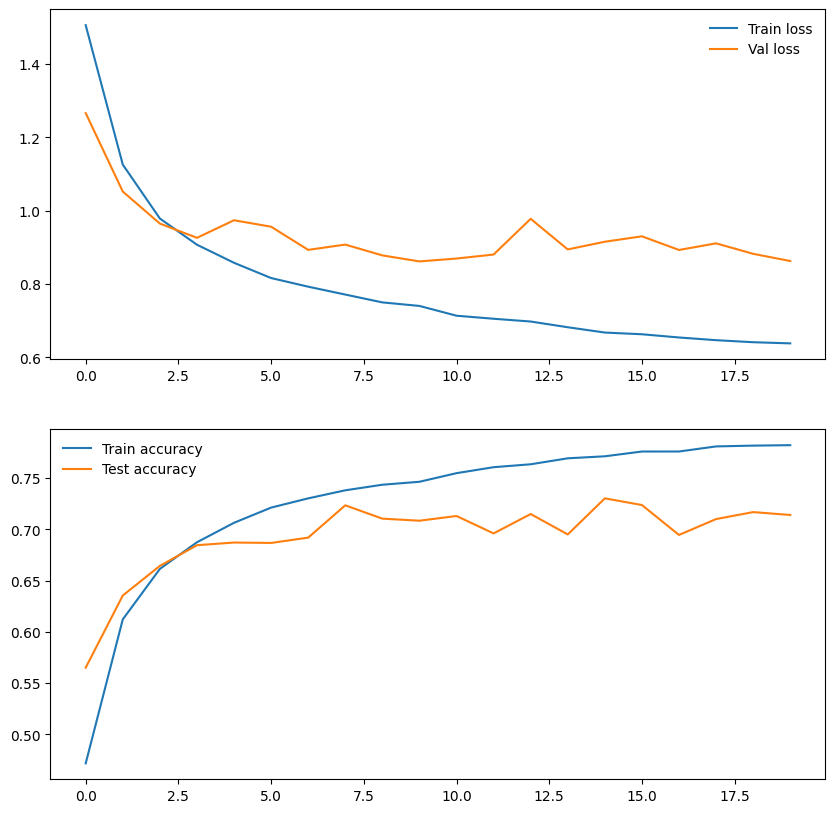

In [ ]:
train_test_info(history)

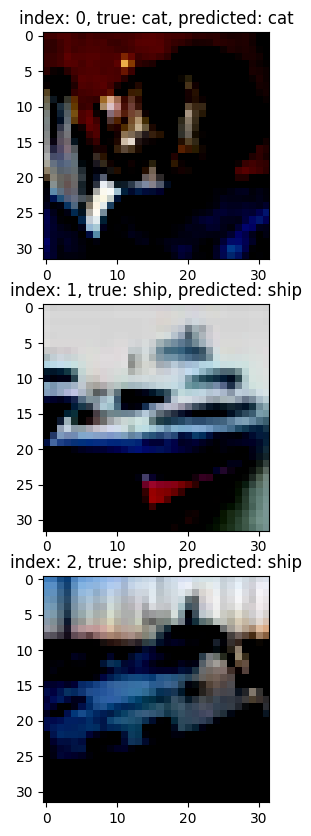

In [ ]:
show_images(model, test_dl, test_dataset, image_size=(3, 32, 32), figsize=(10, 10), linear=False, onedim=False)

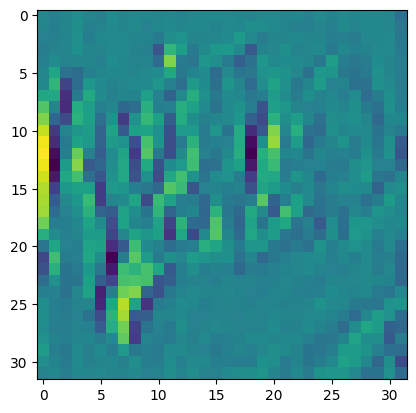

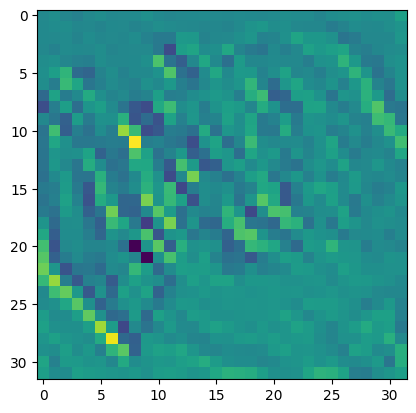

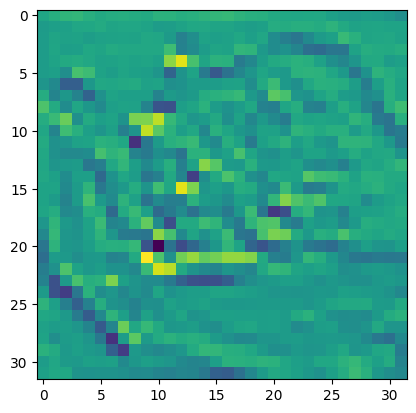

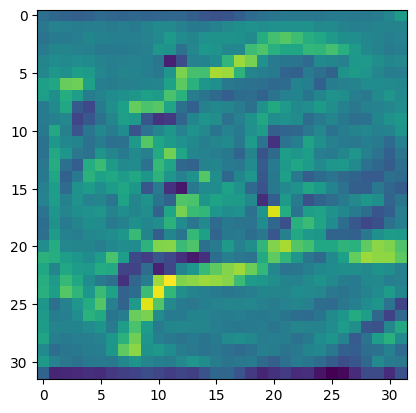

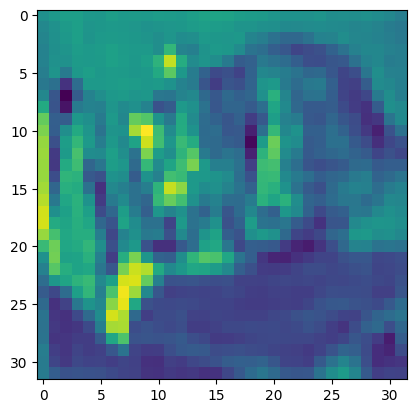

In [ ]:
proccess_image(model, test_dl, linear=False)

total accuracy: 0.758


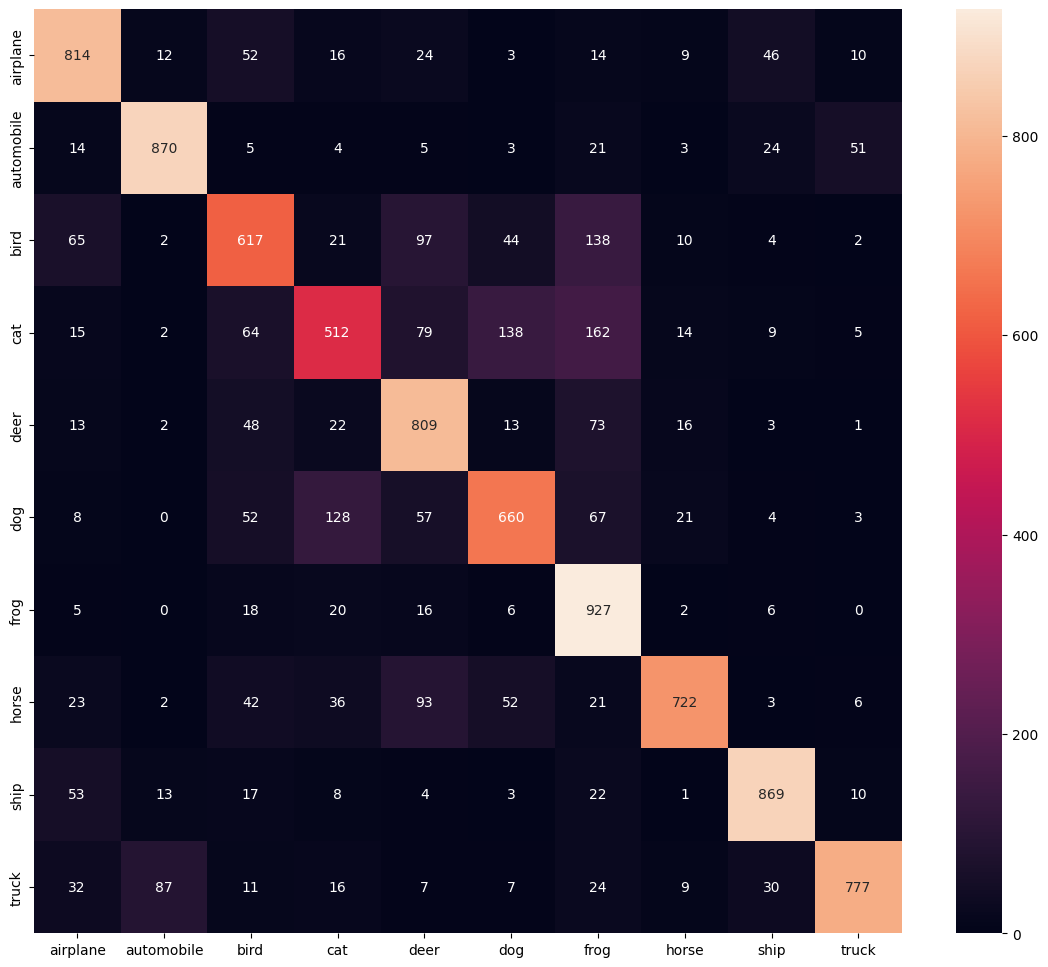

In [ ]:
conf_mat(model, test_dl, test_dataset, linear=False)

## 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:18<00:00, 75.82it/s] 


In [ ]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder('/content/training/training', transform=transforms.Compose(
        [
            torchvision.transforms.Resize((512, 512)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
)

test_dataset = ImageFolder('/content/validation/validation', transform=transforms.Compose(
        [
            torchvision.transforms.Resize((512, 512)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
)

train_dl = torch.utils.data.DataLoader(train_dataset, 16, shuffle=True, pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_dataset, 16, pin_memory=True)

In [ ]:
test_dataset.classes = ['mantled_howler', 'patas_monkey', 'bald_uakari', 'japanese_macaque', 'pygmy_marmoset', 'white_headed_capuchin', 'silvery_marmoset', 'common_squirrel_monkey', 'black_headed_night_monkey', 'nilgiri_langur']

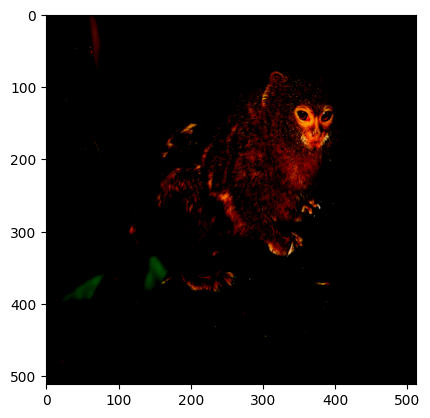

In [ ]:
pic = next(iter(train_dl))[0][0]
plt.imshow(pic.permute(1, 2, 0))

In [ ]:
dp = 0.3
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 16, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.Conv2d(16, 128, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.Conv2d(128, 128, (3, 3), stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.Dropout(dp),

    torch.nn.Flatten(),
    torch.nn.Linear(7*7*128, 64),
    torch.nn.CELU(),
    torch.nn.Linear(64, 10)
).to(device)


In [ ]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 568714


In [ ]:
model, history = train(model, train_dl, test_dl, epochs=20, learning_rate=0.0001, linear=False)

epoch[1]: train loss - 2.107, train accuracy - 0.272, val loss - 1.834, test accuracy - 0.390
epoch[5]: train loss - 0.955, train accuracy - 0.680, val loss - 1.147, test accuracy - 0.599
epoch[10]: train loss - 0.507, train accuracy - 0.844, val loss - 1.026, test accuracy - 0.662
epoch[15]: train loss - 0.228, train accuracy - 0.946, val loss - 1.109, test accuracy - 0.673
epoch[20]: train loss - 0.097, train accuracy - 0.980, val loss - 1.295, test accuracy - 0.706


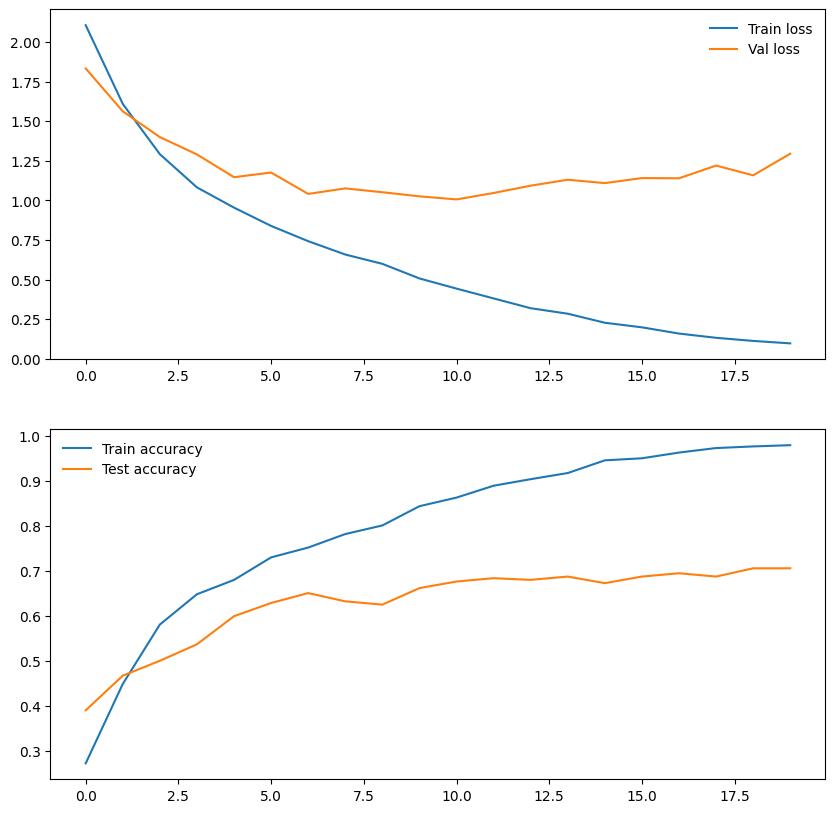

In [ ]:
train_test_info(history)

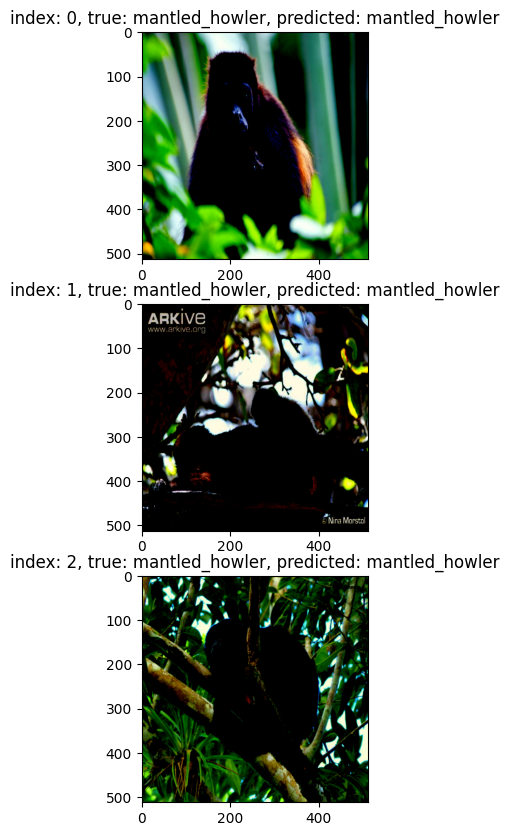

In [ ]:
show_images(model, test_dl, test_dataset, image_size=(3, 512, 512), figsize=(10, 10), linear=False, onedim=False)

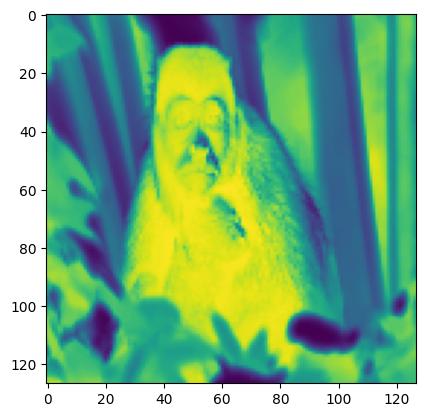

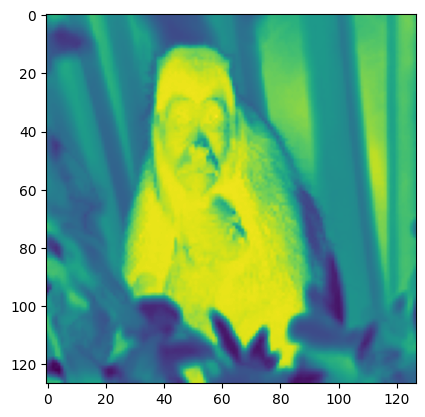

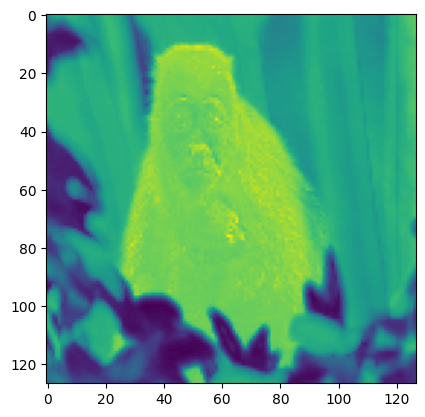

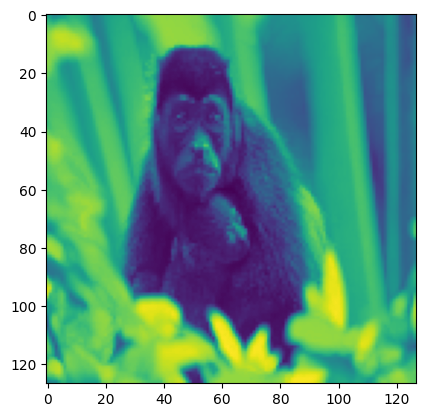

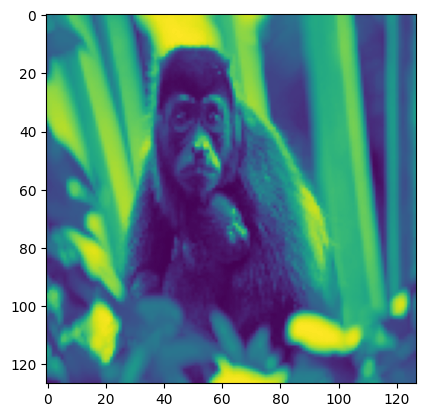

In [ ]:
proccess_image(model, test_dl, linear=False)

total accuracy: 0.713


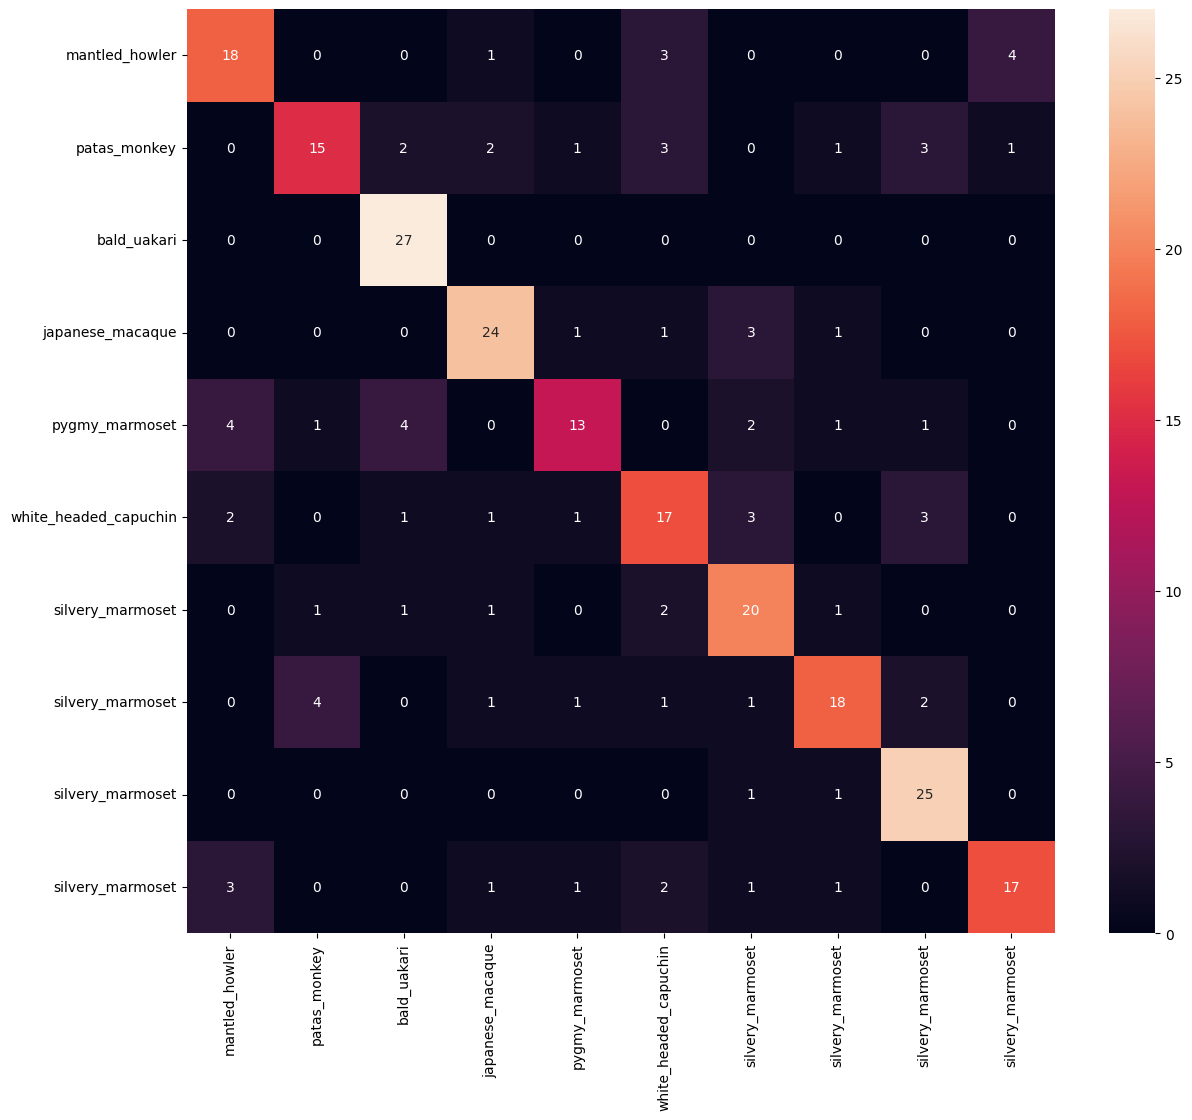

In [ ]:
conf_mat(model, test_dl, test_dataset, linear=False)

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью.

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 25004/25004 [00:25<00:00, 963.45it/s] 


In [ ]:
dataset =  datasets.ImageFolder(
    '/content/cats_dogs/train',
    transform=transforms.Compose([
        transforms.Resize((224, 224), antialias=None),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dl = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32, shuffle=False)

train_dataset.classes = ['cat', 'dog']
test_dataset.classes = ['cat', 'dog']

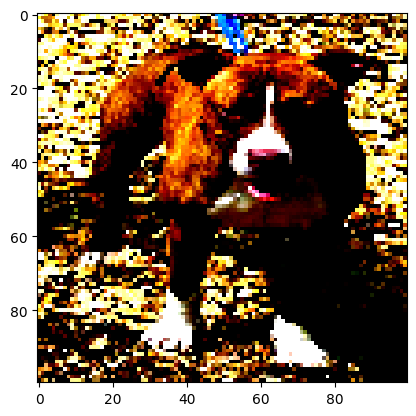

In [ ]:
pic = next(iter(train_dl))[0][0]
plt.imshow(pic.permute(1, 2, 0))

In [ ]:
dp = 0.6
model = torch.nn.Sequential(
    torch.nn.BatchNorm2d(3),
    torch.nn.Conv2d(3, 8, 5, padding=3, stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(8),
    torch.nn.Conv2d(8, 64, 3, stride=2),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.BatchNorm2d(64),
    torch.nn.Conv2d(64, 128, 3),
    torch.nn.MaxPool2d((2, 2)),
    torch.nn.CELU(),

    torch.nn.Dropout(dp),

    torch.nn.Flatten(),
    torch.nn.Linear(128*2*2, 64),
    torch.nn.CELU(),
    torch.nn.Linear(64, 2)
).to(device)

In [ ]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 112248


In [ ]:
model, history = train(model, train_dl, test_dl, epochs=10, learning_rate=0.0005, linear=False)

epoch[1]: train loss - 0.602, train accuracy - 0.671, val loss - 0.549, test accuracy - 0.721
epoch[2]: train loss - 0.538, train accuracy - 0.728, val loss - 0.522, test accuracy - 0.742
epoch[3]: train loss - 0.505, train accuracy - 0.751, val loss - 0.501, test accuracy - 0.754
epoch[4]: train loss - 0.477, train accuracy - 0.769, val loss - 0.477, test accuracy - 0.762
epoch[5]: train loss - 0.461, train accuracy - 0.779, val loss - 0.473, test accuracy - 0.778
epoch[6]: train loss - 0.434, train accuracy - 0.796, val loss - 0.450, test accuracy - 0.785
epoch[7]: train loss - 0.411, train accuracy - 0.810, val loss - 0.454, test accuracy - 0.792
epoch[8]: train loss - 0.392, train accuracy - 0.821, val loss - 0.464, test accuracy - 0.779
epoch[9]: train loss - 0.378, train accuracy - 0.828, val loss - 0.427, test accuracy - 0.802
epoch[10]: train loss - 0.351, train accuracy - 0.843, val loss - 0.438, test accuracy - 0.799


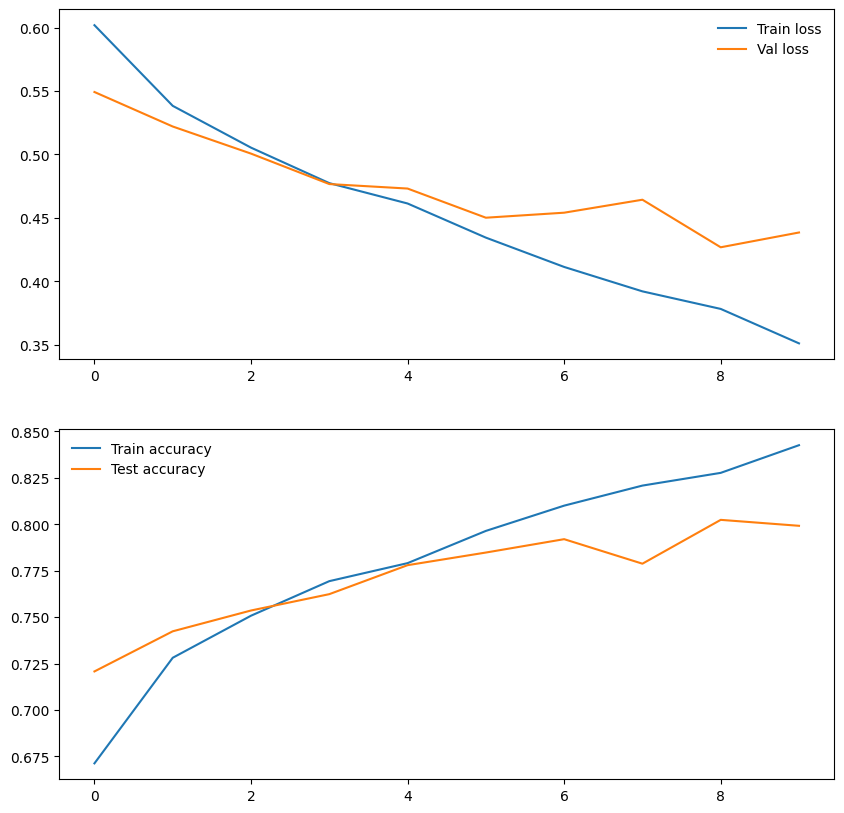

In [ ]:
train_test_info(history)

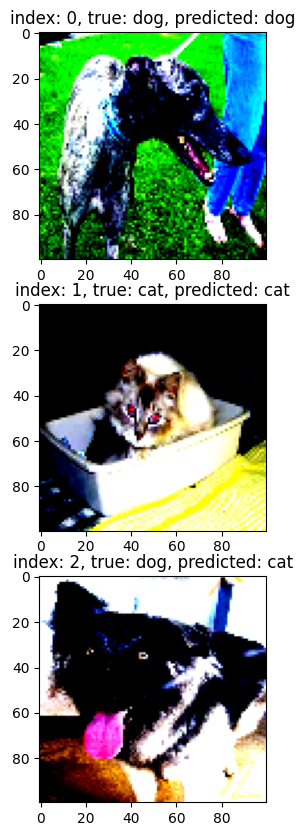

In [ ]:
show_images(model, test_dl, test_dataset, image_size=(3, 100, 100), figsize=(10, 10), linear=False, onedim=False)

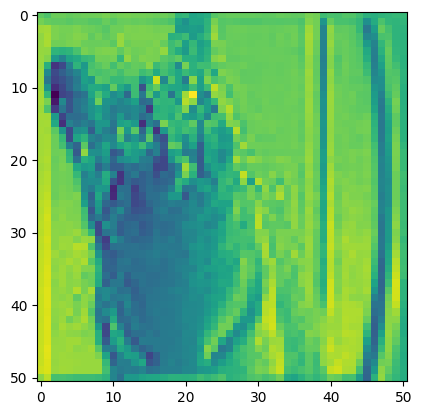

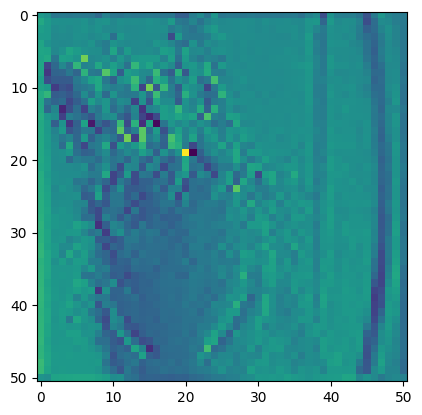

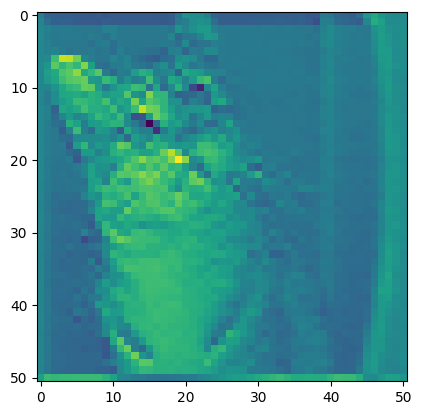

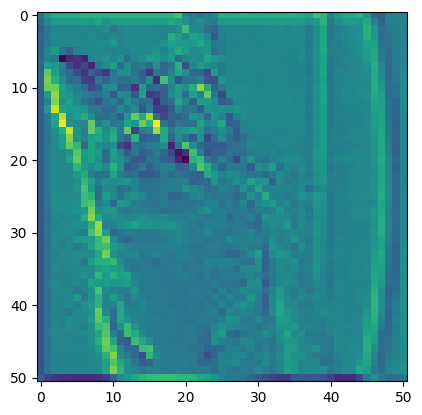

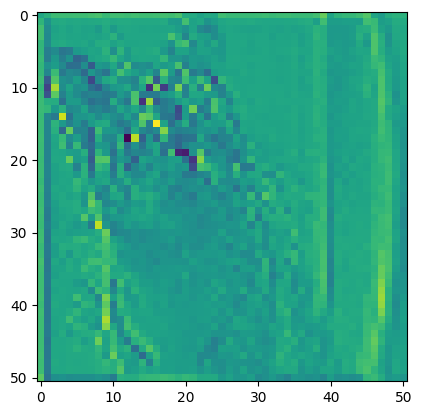

In [ ]:
proccess_image(model, test_dl, linear=False)

total accuracy: 0.823


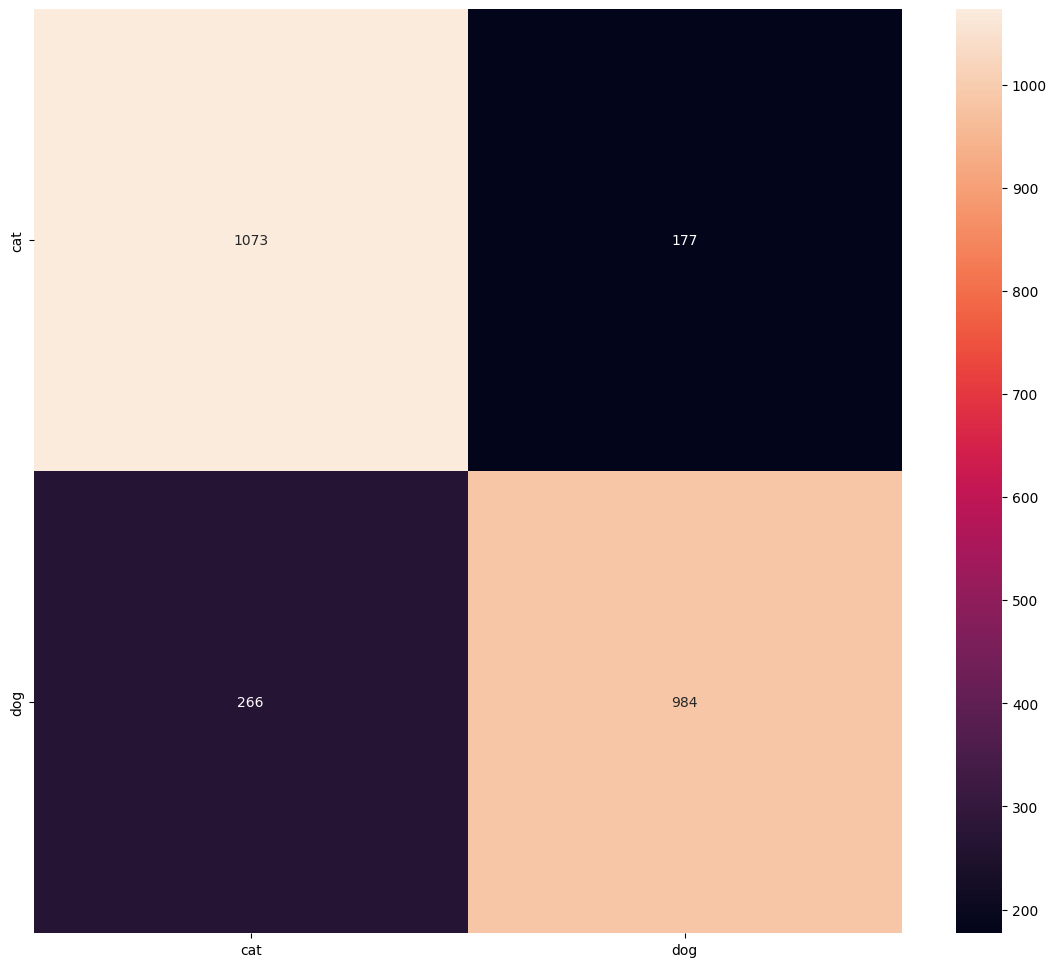

In [ ]:
conf_mat(model, test_dl, test_dataset, linear=False)

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)).
* Вычислить значение accuracy на тестовом множестве.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zf = zipfile.ZipFile('drive/MyDrive/datasets/monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 1371/1371 [00:07<00:00, 178.31it/s]


In [ ]:
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224, 224], antialias=None),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
]
)

train_dataset = datasets.ImageFolder('/content/training/training', transform=transform)

test_dataset = datasets.ImageFolder('/content/validation/validation', transform=transform)


train_dl = torch.utils.data.DataLoader(train_dataset, 16, shuffle=True, pin_memory=True)
test_dl = torch.utils.data.DataLoader(test_dataset, 16, pin_memory=True)

In [ ]:
test_dataset.classes = ['mantled_howler', 'patas_monkey', 'bald_uakari', 'japanese_macaque', 'pygmy_marmoset', 'white_headed_capuchin', 'silvery_marmoset', 'common_squirrel_monkey', 'black_headed_night_monkey', 'nilgiri_langur']

#### Без заморозки весов

In [ ]:
vgg16 = models.vgg16()
vgg16.classifier[6] = torch.nn.Linear(4096, len(test_dataset.classes))

In [ ]:
vgg16 = vgg16.to(device)
param_num = sum(p.numel() for p in vgg16.parameters())
print("Количество параметров:", param_num)

Количество параметров: 134301514


In [ ]:
vgg16, history = train(vgg16, train_dl, test_dl, epochs=5, learning_rate=0.005, linear=False)

epoch[1]: train loss - 7533430.000, train accuracy - 0.114, val loss - 2.335, test accuracy - 0.092
epoch[2]: train loss - 5.209, train accuracy - 0.103, val loss - 2.327, test accuracy - 0.096
epoch[3]: train loss - 63.778, train accuracy - 0.096, val loss - 2.308, test accuracy - 0.132
epoch[4]: train loss - 2.310, train accuracy - 0.111, val loss - 2.303, test accuracy - 0.088
epoch[5]: train loss - 2.307, train accuracy - 0.094, val loss - 2.304, test accuracy - 0.103


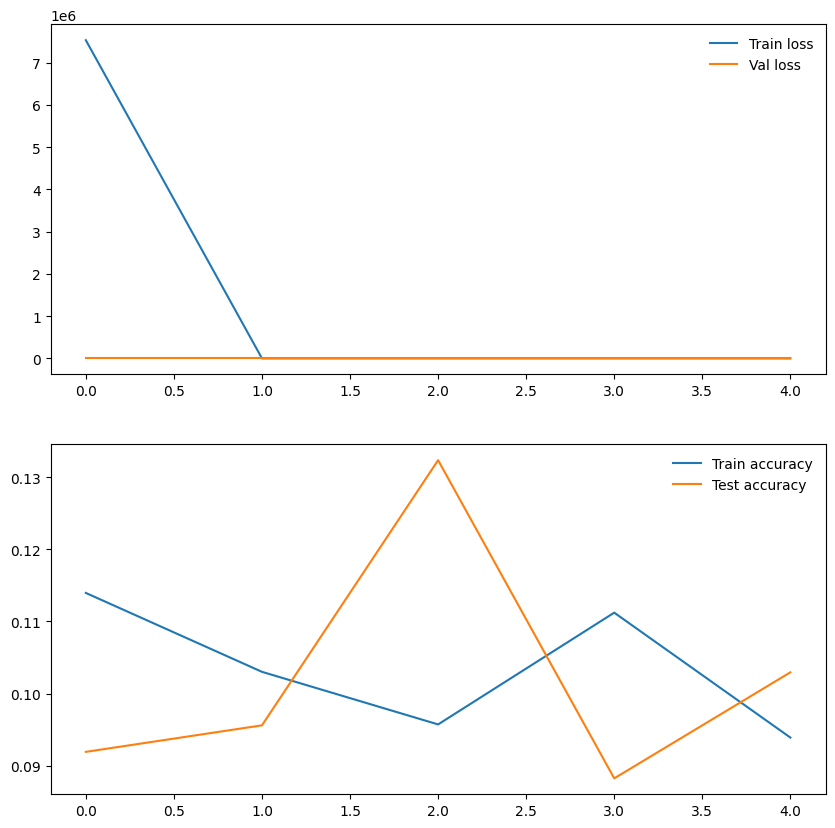

In [ ]:
train_test_info(history)

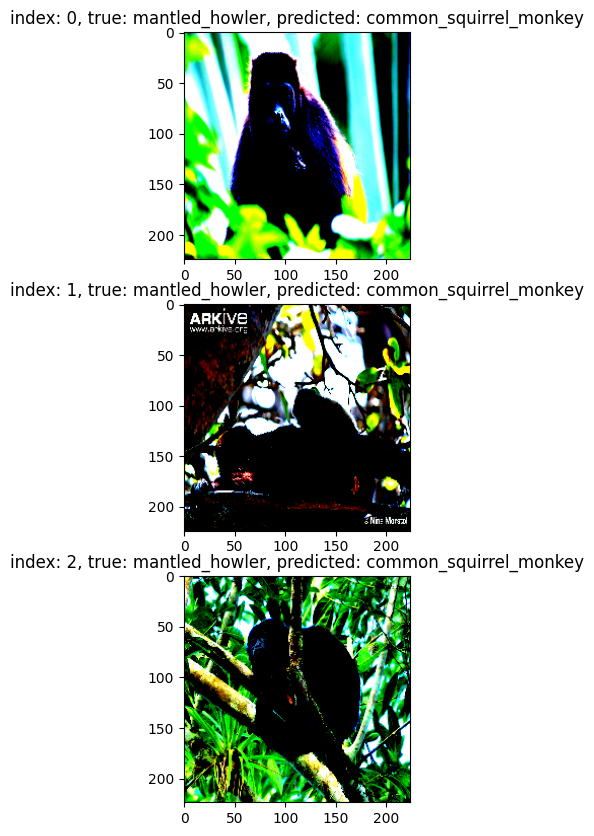

In [ ]:
show_images(vgg16, test_dl, test_dataset, image_size=(3, 224, 224), figsize=(10, 10), linear=False, onedim=False)

total accuracy: 0.103


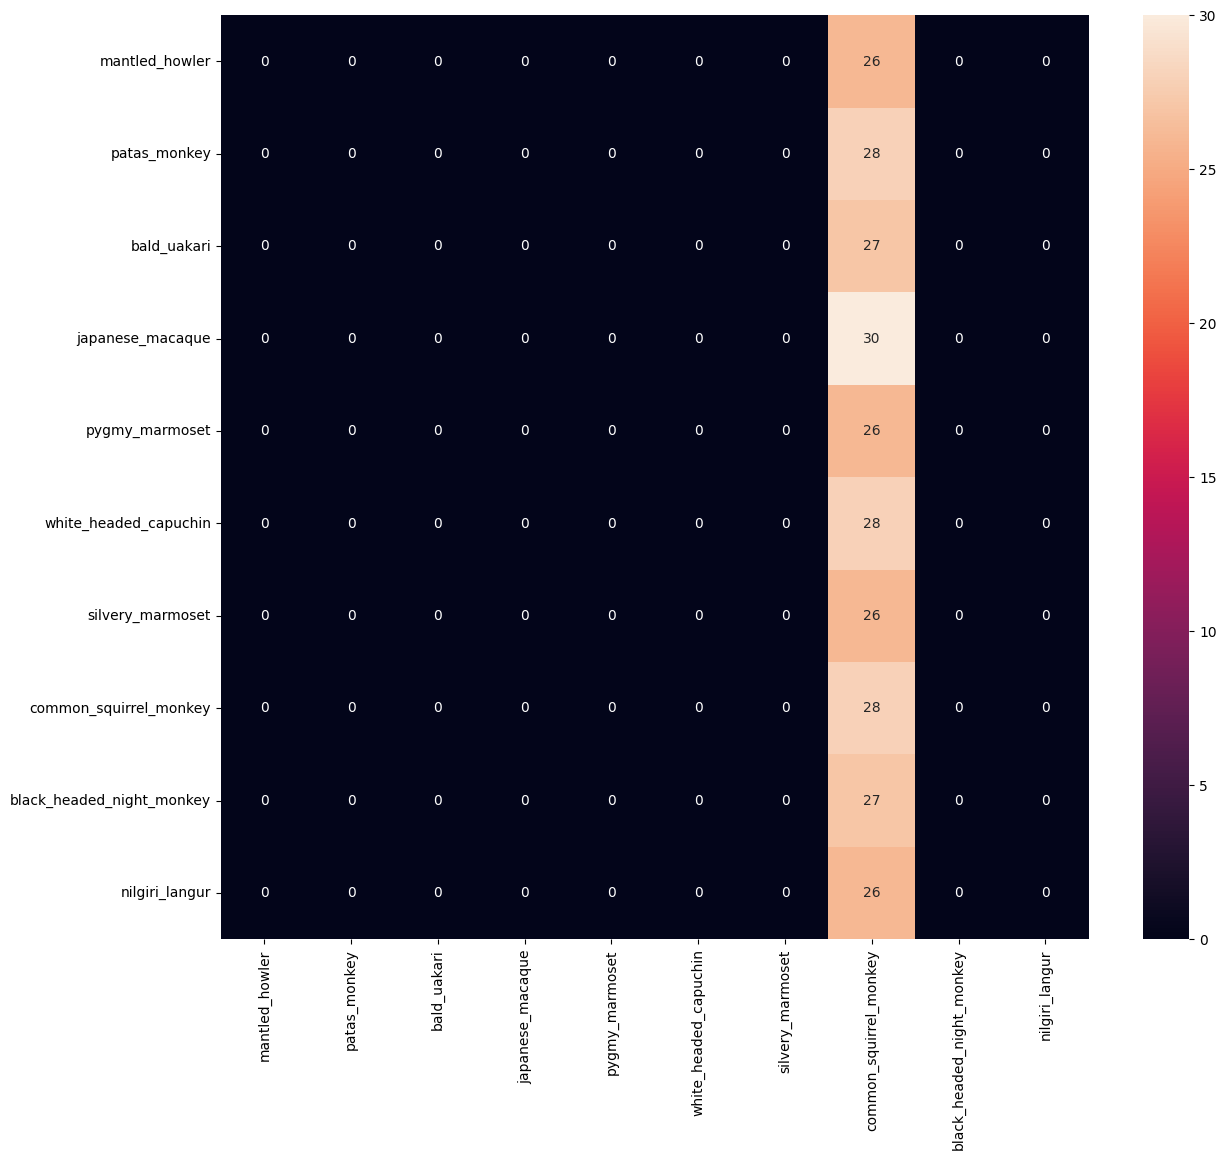

In [ ]:
conf_mat(vgg16, test_dl, test_dataset, linear=False)

#### С заморозкой весов

In [ ]:
vgg16 = models.vgg16(weights='IMAGENET1K_V1')
for param in vgg16.features.parameters():
    param.requires_grad = False
vgg16.classifier[-1] = torch.nn.Linear(4096, len(test_dataset.classes))
vgg16 = vgg16.to(device)

param_num = sum(p.numel() for p in vgg16.parameters())
print("Количество параметров:", param_num)

Количество параметров: 134301514


In [ ]:
vgg16, history = train(vgg16, train_dl, test_dl, epochs=5, learning_rate=0.001, linear=False)

epoch[1]: train loss - 1.466, train accuracy - 0.736, val loss - 1.208, test accuracy - 0.882
epoch[2]: train loss - 1.621, train accuracy - 0.898, val loss - 2.641, test accuracy - 0.879
epoch[3]: train loss - 1.769, train accuracy - 0.927, val loss - 3.925, test accuracy - 0.860
epoch[4]: train loss - 2.057, train accuracy - 0.925, val loss - 5.826, test accuracy - 0.860
epoch[5]: train loss - 1.242, train accuracy - 0.966, val loss - 2.875, test accuracy - 0.945


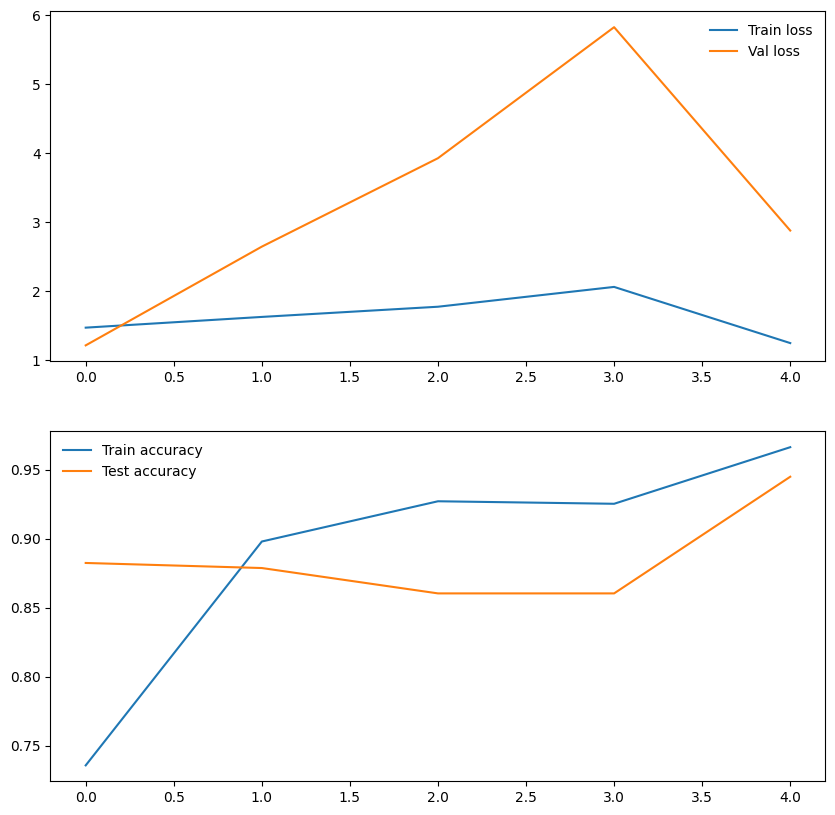

In [ ]:
train_test_info(history)

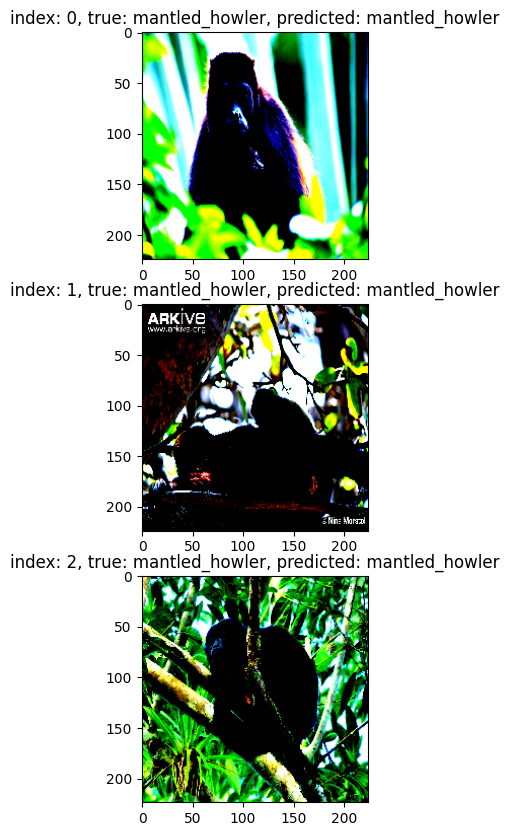

In [ ]:
show_images(vgg16, test_dl, test_dataset, image_size=(3, 224, 224), figsize=(10, 10), linear=False, onedim=False)

total accuracy: 0.963


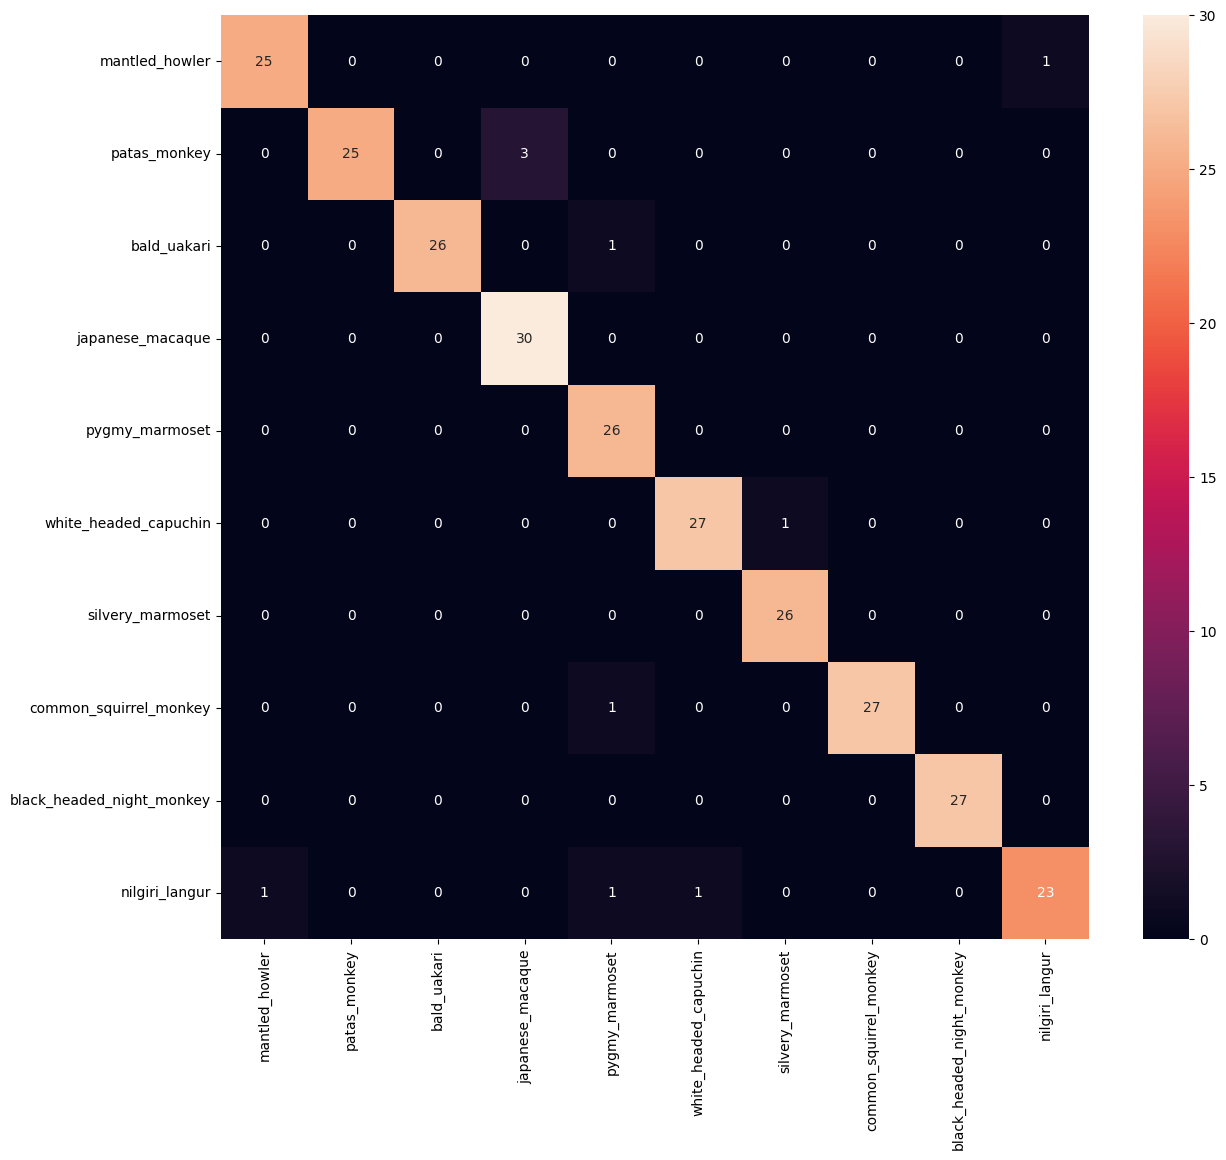

In [ ]:
conf_mat(vgg16, test_dl, test_dataset, linear=False)

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель.
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zf = zipfile.ZipFile('/content/drive/MyDrive/datasets/cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file)

100%|██████████| 25004/25004 [00:12<00:00, 1984.18it/s]


In [ ]:
dataset =  datasets.ImageFolder(
    '/content/cats_dogs/train',
    transform=transforms.Compose([
        transforms.Resize((224, 224), antialias=None),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dl = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32, shuffle=False)

train_dataset.classes = ['cat', 'dog']
test_dataset.classes = ['cat', 'dog']


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:

model.classifier[-1] = torch.nn.Linear(4096, len(test_dataset.classes))
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 57012034


In [ ]:
model, history = train(model, train_dl, test_dl, epochs=10, learning_rate=0.0001, linear=False)

epoch[1]: train loss - 0.130, train accuracy - 0.949, val loss - 0.145, test accuracy - 0.941
epoch[5]: train loss - 0.026, train accuracy - 0.990, val loss - 0.133, test accuracy - 0.963
epoch[10]: train loss - 0.019, train accuracy - 0.994, val loss - 0.147, test accuracy - 0.965


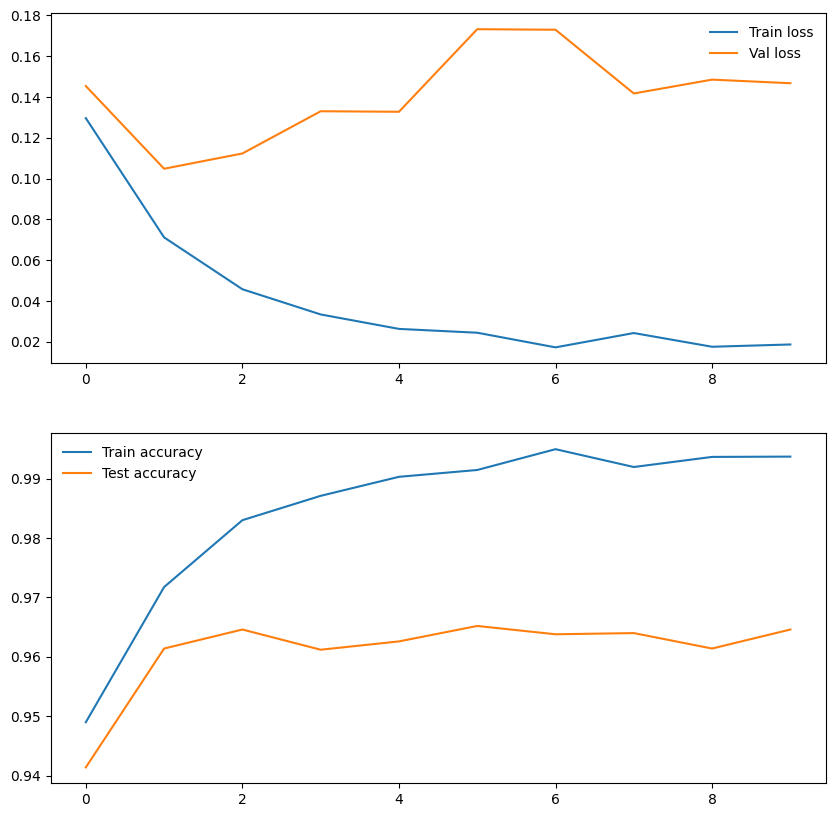

In [ ]:
train_test_info(history)

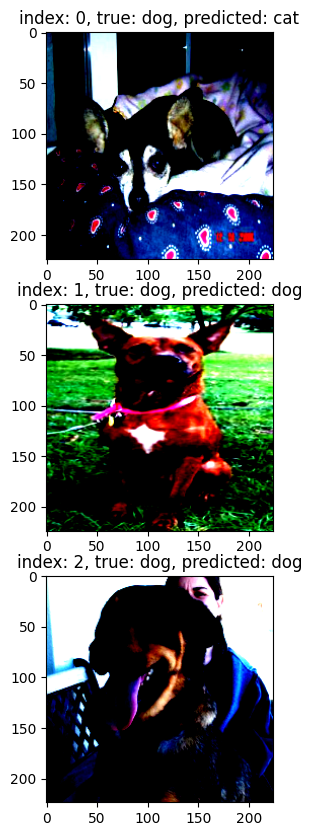

In [ ]:
show_images(model, test_dl, test_dataset, image_size=(3, 224, 224), figsize=(10, 10), linear=False, onedim=False)

total accuracy: 0.966


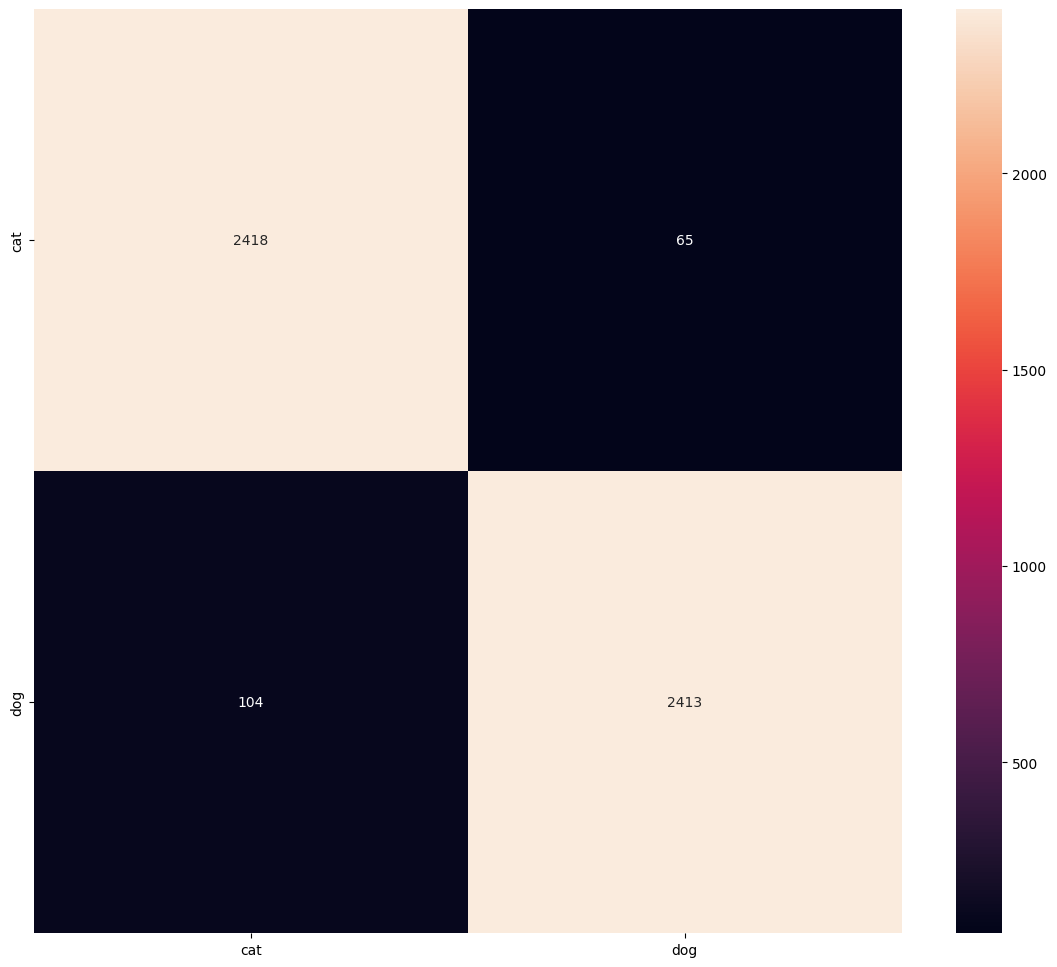

In [ ]:
conf_mat(model, test_dl, test_dataset, linear=False)